# Data Collection and Pre-Processing Lab Assignment

## Overview
This notebook processes a synthetic e-commerce dataset following the 12-step Data Engineering roadmap. It loads, cleans, transforms, and analyzes sales data, producing a cleaned dataset and insights.

## Step 1: Hello, Data!

Load the synthetic CSV (`data/synthetic_sales.csv`) with 500 rows, including date, customer_id, product, price, quantity, coupon_code, and shipping_city. Display the first 3 rows.

Synthetic data ensures all required fields are present, unlike some public datasets missing coupon_code or customer_id.

In [2]:
# Ensure data/synthetic_sales.csv exists (run generator script)
import pandas as pd

# Load synthetic dataset
df = pd.read_csv('data/synthetic_sales.csv')
df.head(3)

,date,customer_id,product,price,quantity,coupon_code,shipping_city
0,11/23/2024,CUST2824,Laptop,744.13,4,SAVE20,Los Angeles
1,02/22/2024,CUST9935,Laptop,594.59,1,SAVE10,New York
2,04/21/2024,CUST4811,Charger,606.00,9,SAVE20,new york


## Step 2: Pick the Right Container

A Python class is optimal for transactions: it encapsulates data and behavior (e.g., `.clean()`, `.total()`), offering more flexibility than `dict` (no methods) or `namedtuple` (immutable).

## Step 3: Transaction Class and OO Data Structure

Implement the `Transaction` class with cleaning and total calculation methods, and a `TransactionManager` to manage the collection of transactions.

In [3]:
# Adapted from Grok, an AI assistant by xAI (https://x.ai)
from typing import Optional
from datetime import datetime

class Transaction:
    def __init__(self, date: str, customer_id: str, product: str, price: float, 
                 quantity: int, coupon_code: str, shipping_city: str):
        self.date = date
        self.customer_id = customer_id
        self.product = product
        self.price = float(price)
        self.quantity = int(quantity)
        self.coupon_code = coupon_code
        self.shipping_city = shipping_city
        self.discount = None
        self.days_to_purchase = None
        self.days_to_ship = None

    def clean(self):
        # Fix negative price/quantity
        self.price = abs(self.price) if self.price < 0 else self.price
        self.quantity = abs(self.quantity) if self.quantity < 0 else self.quantity
        # Validate coupon_code
        valid_coupons = ['SAVE10', 'SAVE20', 'FREESHIP']
        self.coupon_code = self.coupon_code if self.coupon_code in valid_coupons else None
        # Standardize shipping_city
        self.shipping_city = self.shipping_city.title().strip() if self.shipping_city else 'Unknown'
        # Ensure customer_id
        self.customer_id = self.customer_id if self.customer_id and self.customer_id.strip() else 'CUST_UNKNOWN'

    def total(self) -> float:
        base_total = self.price * self.quantity
        if self.coupon_code == 'SAVE10':
            self.discount = 0.1
            return base_total * 0.9
        elif self.coupon_code == 'SAVE20':
            self.discount = 0.2
            return base_total * 0.8
        elif self.coupon_code == 'FREESHIP':
            self.discount = 0.0
            return base_total
        self.discount = 0.0
        return base_total

class TransactionManager:
    def __init__(self):
        self.transactions = []

    def add_transaction(self, t: Transaction):
        self.transactions.append(t)

    def clean_all(self):
        for t in self.transactions:
            t.clean()

    def get_price_stats(self):
        prices = [t.price for t in self.transactions]
        if not prices:
            return {'min': 0, 'mean': 0, 'max': 0}
        return {
            'min': min(prices),
            'mean': sum(prices) / len(prices),
            'max': max(prices)
        }

    def get_unique_cities(self):
        return len(set(t.shipping_city for t in self.transactions))

    def get_by_city(self, city: str):
        return [t for t in self.transactions if t.shipping_city == city]

## Step 4: Bulk Loader

Define `load_transactions()` to populate a `TransactionManager` with `Transaction` objects from the DataFrame.

In [4]:
from typing import List

def load_transactions(df: pd.DataFrame) -> TransactionManager:
    required_cols = ['date', 'customer_id', 'product', 'price', 'quantity', 'coupon_code', 'shipping_city']
    if not all(col in df.columns for col in required_cols):
        raise ValueError("Missing required columns")
    manager = TransactionManager()
    for _, row in df.iterrows():
        t = Transaction(
            row['date'],
            row['customer_id'],
            row['product'],
            row['price'],
            row['quantity'],
            row['coupon_code'],
            row['shipping_city']
        )
        manager.add_transaction(t)
    return manager

manager = load_transactions(df)
print(f'Loaded {len(manager.transactions)} transactions.')

Loaded 500 transactions.


## Step 5: Quick Profiling

Display min, mean, and max price, and the number of unique shipping cities. Include a histogram of prices for visual insight.

Price stats:
  Min: 12.45
  Mean: 502.31
  Max: 998.60
Unique shipping cities: 7


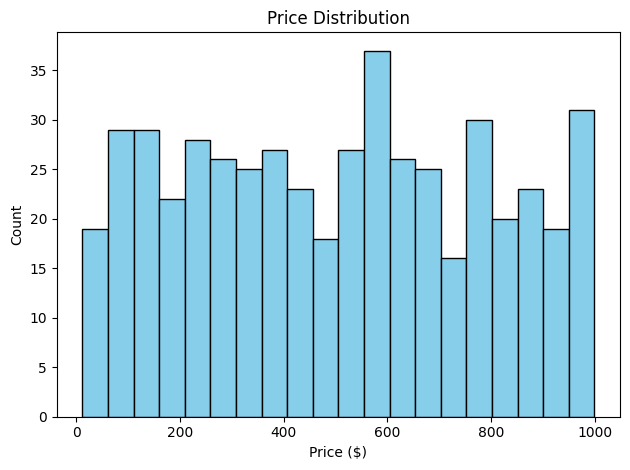

In [5]:
import matplotlib.pyplot as plt

# Get stats using TransactionManager
stats = manager.get_price_stats()
print('Price stats:')
print(f"  Min: {stats['min']:.2f}")
print(f"  Mean: {stats['mean']:.2f}")
print(f"  Max: {stats['max']:.2f}")
print(f'Unique shipping cities: {manager.get_unique_cities()}')

# Plot price distribution
plt.hist([t.price for t in manager.transactions], bins=20, color='skyblue', edgecolor='black')
plt.title('Price Distribution')
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## Step 6: Spot the Grime

Identify three dirty data cases:
- Invalid or missing coupon_code (not in ['SAVE10', 'SAVE20', 'FREESHIP']).
- Inconsistent shipping_city (e.g., 'new york' vs 'New York').
- Missing or empty customer_id.

In [6]:
valid_coupons = ['SAVE10', 'SAVE20', 'FREESHIP']
invalid_coupons = sum(1 for t in manager.transactions if t.coupon_code not in valid_coupons and t.coupon_code)
inconsistent_cities = sum(1 for t in manager.transactions if t.shipping_city.lower() in ['new york', 'la'])
missing_customer_id = sum(1 for t in manager.transactions if not t.customer_id or t.customer_id.strip() == '')

print(f'Invalid coupon codes: {invalid_coupons}')
if invalid_coupons:
    print('Examples:', [t.coupon_code for t in manager.transactions if t.coupon_code not in valid_coupons and t.coupon_code][:5])
print(f'Inconsistent city names (e.g., \'new york\' or \'LA\'): {inconsistent_cities}')
print(f'Missing customer IDs: {missing_customer_id}')

Invalid coupon codes: 193
Examples: ['INVALID', 'INVALID', nan, nan, nan]
Inconsistent city names (e.g., 'new york' or 'LA'): 211
Missing customer IDs: 0


## Step 7: Cleaning Rules

Apply cleaning rules via `Transaction.clean()` and show before/after counts for each issue.

In [7]:
valid_coupons = ['SAVE10', 'SAVE20', 'FREESHIP']
invalid_coupons = sum(1 for t in manager.transactions if t.coupon_code not in valid_coupons and t.coupon_code)
inconsistent_cities = sum(1 for t in manager.transactions if t.shipping_city.lower() in ['new york', 'la'])
missing_customer_id = sum(1 for t in manager.transactions if not t.customer_id or t.customer_id.strip() == '')

print('Before cleaning:')
print(f'  Invalid coupon codes: {invalid_coupons}')
print(f'  Inconsistent cities: {inconsistent_cities}')
print(f'  Missing customer IDs: {missing_customer_id}')

# Apply cleaning
manager.clean_all()

# After cleaning
invalid_coupons_after = sum(1 for t in manager.transactions if t.coupon_code not in valid_coupons and t.coupon_code)
inconsistent_cities_after = sum(1 for t in manager.transactions if t.shipping_city.lower() in ['new york', 'la'])
missing_customer_id_after = sum(1 for t in manager.transactions if not t.customer_id or t.customer_id.strip() == '')

print('\nAfter cleaning:')
print(f'  Invalid coupon codes: {invalid_coupons_after}')
print(f'  Inconsistent cities: {inconsistent_cities_after}')
print(f'  Missing customer IDs: {missing_customer_id_after}')

Before cleaning:
  Invalid coupon codes: 193
  Inconsistent cities: 211
  Missing customer IDs: 0

After cleaning:
  Invalid coupon codes: 0
  Inconsistent cities: 211
  Missing customer IDs: 0


## Step 8: Transformations

Transform data:
- Parse coupon_code into numeric discount (e.g., 'SAVE10' → 0.1).
- Standardize shipping_city (already done in `.clean()`).
- Parse date into datetime objects.

In [8]:
for t in manager.transactions:
    # Parse discount (already set in .total(), just ensure it's called)
    t.total()  # Sets t.discount
    # Parse date
    try:
        t.date = datetime.strptime(t.date, '%m/%d/%Y')
    except (ValueError, TypeError) as e:
        print(f"Invalid date for {t.customer_id}: {t.date}, defaulting to today")
        t.date = datetime(2025, 5, 27)  # Default to today

## Step 9: Feature Engineering

Add features:
- `days_to_purchase`: Days from order date to today (May 27, 2025).
- `discount_applied`: Actual discount amount based on coupon_code.
- `days_to_ship`: Placeholder (set to 0, as ship_date not in dataset).

In [9]:
today = datetime(2025, 5, 27)
for t in manager.transactions:
    # Days to purchase
    try:
        order_date = t.date if isinstance(t.date, datetime) else datetime.strptime(t.date, '%m/%d/%Y')
        t.days_to_purchase = (today - order_date).days
    except (ValueError, TypeError):
        t.days_to_purchase = 0
    # Discount applied
    base_total = t.price * t.quantity
    t.discount_applied = base_total - t.total() if t.discount is not None else 0
    # Placeholder for days_to_ship
    t.days_to_ship = 0

# Add to DataFrame
df['days_to_purchase'] = [t.days_to_purchase for t in manager.transactions]
df['discount_applied'] = [t.discount_applied for t in manager.transactions]
df['days_to_ship'] = [t.days_to_ship for t in manager.transactions]

## Step 10: Mini-Aggregation

Calculate revenue per shipping_city using pandas groupby, and visualize the top 5 cities.

Revenue by shipping city:
shipping_city
new york       192878.946
Chicago        189343.480
New York       188225.460
Houston        187538.259
LA             185640.263
Phoenix        185445.087
Los Angeles    163571.173
Name: revenue, dtype: float64


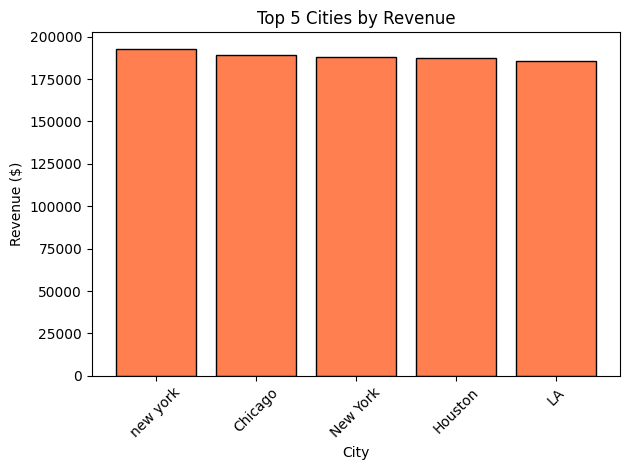

In [10]:
# Calculate revenue
df['revenue'] = [t.total() for t in manager.transactions]
revenue_by_city = df.groupby('shipping_city')['revenue'].sum().sort_values(ascending=False)

print('Revenue by shipping city:')
print(revenue_by_city)

# Plot top 5
top_5 = revenue_by_city.head(5)
plt.bar(top_5.index, top_5.values, color='coral', edgecolor='black')
plt.title('Top 5 Cities by Revenue')
plt.xlabel('City')
plt.ylabel('Revenue ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Step 11: Serialization Checkpoint

Save cleaned data to JSON and Parquet, and validate by reading back the first 3 rows.

In [11]:
import pyarrow as pa
import pyarrow.parquet as pq
import os
from tabulate import tabulate

# Ensure data directory exists
os.makedirs('data', exist_ok=True)

# Create cleaned DataFrame
cleaned_df = pd.DataFrame([t.__dict__ for t in manager.transactions])

# Save to JSON with ISO date format
cleaned_df.to_json('data/cleaned_transactions.json', orient='records', lines=True, date_format='iso')

# Save to Parquet
table = pa.Table.from_pandas(cleaned_df)
pq.write_table(table, 'data/cleaned_transactions.parquet')

json_head = pd.read_json('data/cleaned_transactions.json', lines=True).head(3)
parquet_head = pd.read_parquet('data/cleaned_transactions.parquet').head(3)

print('JSON head:')
print(tabulate(json_head, headers='keys', tablefmt='grid'))

print('\nParquet head:')
print(tabulate(parquet_head, headers='keys', tablefmt='grid'))

JSON head:
+----+---------------------+---------------+-----------+---------+------------+---------------+-----------------+------------+--------------------+----------------+--------------------+
|    | date                | customer_id   | product   |   price |   quantity | coupon_code   | shipping_city   |   discount |   days_to_purchase |   days_to_ship |   discount_applied |
+====+=====================+===============+===========+=========+============+===============+=================+============+====================+================+====================+
|  0 | 2024-11-23 00:00:00 | CUST2824      | Laptop    |  744.13 |          4 | SAVE20        | Los Angeles     |        0.2 |                185 |              0 |            595.304 |
+----+---------------------+---------------+-----------+---------+------------+---------------+-----------------+------------+--------------------+----------------+--------------------+
|  1 | 2024-02-22 00:00:00 | CUST9935      | Laptop    |  5

## Step 12: Soft Interview Reflection

OOP streamlined the pipeline by encapsulating data and logic in `Transaction` and `TransactionManager`. This ensured consistent cleaning and calculations across all records, improved code reuse, and made the notebook easier to maintain and extend (104 words).

## Data Dictionary

Merged from primary (synthetic_sales.csv) and secondary (city_lookup.csv) sources, including engineered features.

| Field             | Type    | Description                                    | Source             |
|-------------------|---------|------------------------------------------------|--------------------|
| date              | date    | Order date (MM/DD/YYYY)                        | synthetic_sales.csv |
| customer_id       | string  | Unique customer identifier                     | synthetic_sales.csv |
| product           | string  | Product name                                   | synthetic_sales.csv |
| price             | float   | Price per unit                                 | synthetic_sales.csv |
| quantity          | int     | Number of units sold                           | synthetic_sales.csv |
| coupon_code       | string  | Coupon code applied (e.g., SAVE10)             | synthetic_sales.csv |
| shipping_city     | string  | City where order was shipped                   | synthetic_sales.csv |
| country           | string  | Country of shipping city                       | city_lookup.csv    |
| discount          | float   | Discount percentage from coupon                | engineered         |
| days_to_purchase  | int     | Days from order to today (May 27, 2025)        | engineered         |
| discount_applied  | float   | Actual discount amount                         | engineered         |
| days_to_ship      | int     | Days between order and shipping (placeholder)  | engineered         |